In [221]:
# referrence:  https://keras.io/examples/timeseries/timeseries_weather_forecasting/
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [222]:
DATA_DIR = '../../data/data_daily_with_aqi.csv'
raw_df = pd.read_csv(DATA_DIR)

In [223]:
raw_df.type.unique()

array(['O3_24h', 'NO2_24h', 'SO2_24h', 'PM2.5_24h', 'AQI'], dtype=object)

In [224]:
df = raw_df[raw_df['type']=='AQI'].drop('type',axis=1)


In [225]:
df = df.drop(['date','hour'],axis=1)

In [226]:
for i in range(1,6):
    df['lag'+str(i)] = df['北京'].shift(i)

In [227]:
df = df.fillna(method='ffill')

In [228]:
df = df.dropna(how='any')

In [229]:
df

,北京,天津,石家庄,唐山,秦皇岛,邯郸,保定,张家口,承德,廊坊,沧州,衡水,邢台,lag1,lag2,lag3,lag4,lag5
34,279.0,311.0,449.0,150.0,113.0,445.0,500.0,196.0,151.0,313.0,334.0,369.0,500.0,279.0,258.0,258.0,149.0,149.0
39,20.0,42.0,58.0,63.0,71.0,156.0,103.0,22.0,50.0,43.0,59.0,167.0,231.0,279.0,279.0,258.0,258.0,149.0
44,20.0,42.0,58.0,63.0,71.0,156.0,103.0,22.0,50.0,43.0,59.0,167.0,231.0,20.0,279.0,279.0,258.0,258.0
49,143.0,103.0,93.0,116.0,102.0,65.0,186.0,47.0,59.0,109.0,69.0,95.0,103.0,20.0,20.0,279.0,279.0,258.0
54,143.0,103.0,93.0,116.0,102.0,65.0,186.0,47.0,59.0,109.0,69.0,95.0,103.0,143.0,20.0,20.0,279.0,279.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14664,91.0,103.0,126.0,80.0,41.0,124.0,101.0,103.0,31.0,94.0,110.0,104.0,128.0,89.0,52.0,50.0,86.0,144.0
14669,31.0,35.0,60.0,42.0,35.0,63.0,54.0,23.0,54.0,37.0,36.0,36.0,53.0,91.0,89.0,52.0,50.0,86.0
14674,17.0,33.0,57.0,73.0,46.0,57.0,40.0,21.0,30.0,21.0,49.0,36.0,65.0,31.0,91.0,89.0,52.0,50.0
14679,52.0,54.0,79.0,52.0,52.0,75.0,80.0,25.0,48.0,55.0,44.0,60.0,78.0,17.0,31.0,91.0,89.0,52.0


In [230]:
step = 1
past = 200
future = 15
learning_rate = 1e-2
batch_size = 256
epochs = 500
sequence_length = 1

df = df.apply(np.log).diff(1)


df['label'] = df['北京'].shift(-future)
df =  df.fillna(method='ffill').dropna(how='any',axis=0)
df = df.reset_index(drop=True)

In [231]:

split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))

In [232]:
features = df.reset_index(drop=True)
# features = normalize(features.values, train_split)
# features = pd.DataFrame(features)
# features.head()
train_data = features.iloc[: train_split,:]
val_data = features.iloc[train_split-sequence_length:,:]

In [233]:
x_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values
x_val = val_data.iloc[:,:-1].values
y_val = val_data.iloc[:,-1].values
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_val = x_scaler.transform(x_val)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_val = y_scaler.transform(y_val.reshape(-1,1))


In [234]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [235]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: (256, 1, 18)
Target shape: (256, 1)


In [236]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
outputs = keras.layers.Dense(64)(inputs)
dropout = keras.layers.Dropout(0.2, noise_shape=None, seed=None)(outputs)
outputs2 = keras.layers.Dense(16)(dropout)
outputs3 = keras.layers.Dense(1)(outputs2)

model = keras.Model(inputs=inputs, outputs=outputs3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1, 18)]           0         
                                                                 
 dense_24 (Dense)            (None, 1, 64)             1216      
                                                                 
 dropout_8 (Dropout)         (None, 1, 64)             0         
                                                                 
 dense_25 (Dense)            (None, 1, 16)             1040      
                                                                 
 dense_26 (Dense)            (None, 1, 1)              17        
                                                                 
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________


In [237]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15, verbose=1, mode="auto", baseline=None, restore_best_weights=False)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, 
               modelckpt_callback,
               ],
)

Epoch 1/500
1/9 [==>...........................] - ETA: 7s - loss: 1.5610

2022-05-22 09:46:24.695994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/9 [=========================>....] - ETA: 0s - loss: 1.6696
Epoch 1: val_loss improved from inf to 1.33553, saving model to model_checkpoint.h5
9/9 [==============================] - 1s 37ms/step - loss: 1.6679 - val_loss: 1.3355
Epoch 2/500
4/9 [============>.................] - ETA: 0s - loss: 1.3029

2022-05-22 09:46:25.061101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/9 [=========================>....] - ETA: 0s - loss: 1.2143
Epoch 2: val_loss improved from 1.33553 to 0.96281, saving model to model_checkpoint.h5
9/9 [==============================] - 0s 25ms/step - loss: 1.2129 - val_loss: 0.9628
Epoch 3/500
5/9 [===============>..............] - ETA: 0s - loss: 1.0495
Epoch 3: val_loss improved from 0.96281 to 0.89071, saving model to model_checkpoint.h5
9/9 [==============================] - 0s 21ms/step - loss: 1.0286 - val_loss: 0.8907
Epoch 4/500
5/9 [===============>..............] - ETA: 0s - loss: 1.0141
Epoch 4: val_loss improved from 0.89071 to 0.84387, saving model to model_checkpoint.h5
9/9 [==============================] - 0s 21ms/step - loss: 1.0093 - val_loss: 0.8439
Epoch 5/500
5/9 [===============>..............] - ETA: 0s - loss: 0.9791
Epoch 5: val_loss did not improve from 0.84387
9/9 [==============================] - 0s 29ms/step - loss: 0.9845 - val_loss: 0.8616
Epoch 6/500
9/9 [==============================] - ETA: 0s - 

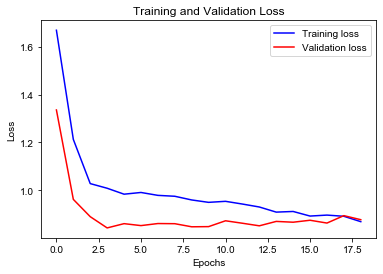

In [238]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [239]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return



4/4 [==============================] - 0s 13ms/step


2022-05-22 09:46:29.121839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'r2_score:-0.0432')

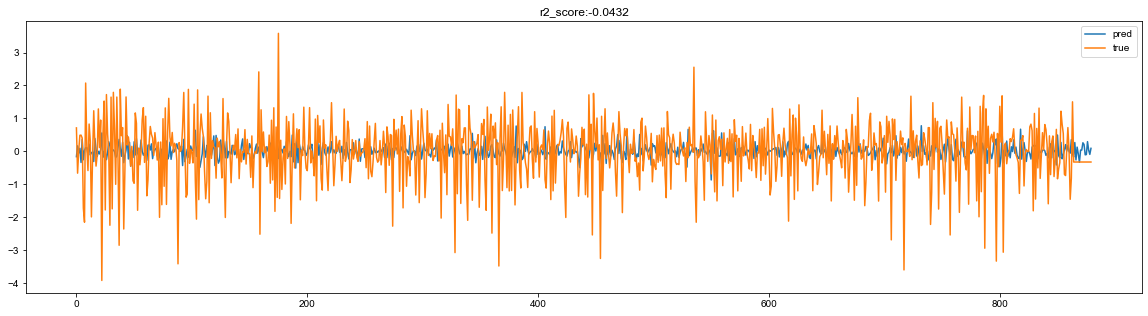

In [240]:
from sklearn.metrics import r2_score
pred = model.predict(dataset_val)
y_pred = pred.flatten()
y_true = y_val.flatten()[-len(y_pred):]
plt.figure(figsize=(20, 5))
plt.plot(y_pred,label = 'pred')
plt.plot(y_true,label='true')
plt.legend()
plt.title('r2_score:{:.4f}'.format(r2_score(y_true,y_pred)))


In [241]:
model.save('./models/lstm_128_dense_1.h5')

9/9 [==============================] - 0s 10ms/step


Text(0.5, 1.0, 'r2_score:-0.0263')

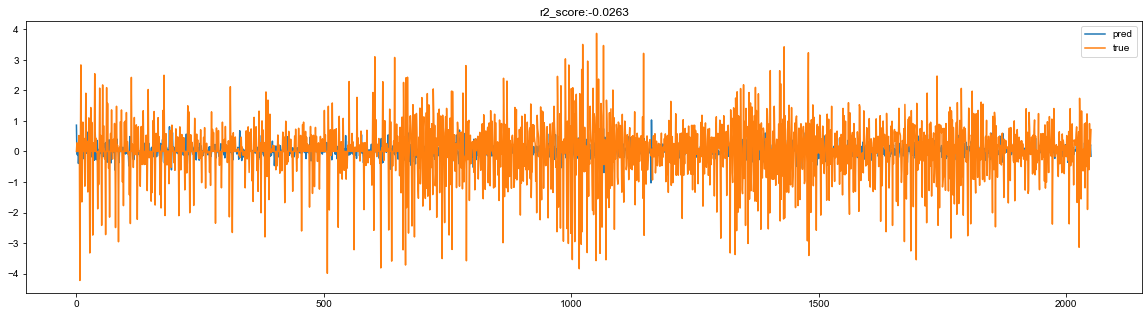

In [242]:
from sklearn.metrics import r2_score
pred = model.predict(dataset_train)
y_pred = pred.flatten()
y_true = y_train.flatten()[-len(y_pred):]
plt.figure(figsize=(20, 5))
plt.plot(y_pred,label = 'pred')
plt.plot(y_true,label='true')
plt.legend()
plt.title('r2_score:{:.4f}'.format(r2_score(y_true,y_pred)))
